In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from utils import lists
from tqdm import tqdm
from scipy.stats import norm
import scipy
import matplotlib.cm as cm


# Read data file

In [2]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
chn = [2048,2048]
header, events, timing = lists.lstRead(FILE_PATH)
coin = [True, True, False, False, False, False, False, False]
zdrop = True
data = np.array(lists.getCoins(events,coin,zdrop))

In [192]:

############ Util functions ############

def make_palette(K):
    # Define colormap and sample K evenly spaced colors
    cmap = plt.cm.plasma
    indices = np.linspace(0, 1, K)
    return [cmap(i) for i in indices]

def sample_fraction(X, phi, y, fraction=0.1, random_seed=None):
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Set random seed for reproducibility if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Calculate the number of samples
    n_samples = int(len(X) * fraction)
    
    # Randomly select indices to sample
    sampled_indices = np.random.choice(len(X), n_samples, replace=False)
    
    # Return the sampled data
    X_sampled = X[sampled_indices]
    y_sampled = y[sampled_indices]
    phi_sampled = phi[sampled_indices]
    return X_sampled, phi_sampled, y_sampled

def plot_predictions(x, y, y_pred, model, size=1, fill=False, beta=0):
    p = model.params()
    colors = cm.rainbow(np.linspace(0, 1, p['K']))
    
    sort_index = np.argsort(x.flatten())
    x = x[sort_index]
    y = y[sort_index]
    y_pred = y_pred[sort_index]
    beta = p['beta']
    if beta != 0:
        beta = beta
    plt.scatter(x, y, c='grey', s=size, alpha=0.3)
    plt.ylabel('ToF (channel)')
    plt.xlabel('Energy (channel)')
    for k in tqdm(range(p['K'])):
        color = colors[k]
        plt.plot(x, y_pred[:,k], color=color, alpha=0.8)
        if fill:
            for i in range(1, 3):
                plt.fill_between(x, 
                                y_pred[:, k] - i*np.sqrt(beta), 
                                y_pred[:, k] + i*np.sqrt(beta), 
                                color=color,
                                alpha=0.3)

In [193]:
class MixtureLinearRegression():
    """Implementation of Mixture of Linear Regressions.

    Parameters
    ----------
    K : int
        Number of components.

    beta : float
        Noise precision hyper parameter

    iterations : int
        How many iterations the EM algorithms should go 

    bias : bool
        Flag for including or excluding bias term
    """    
    def __init__(self, K, beta, iterations, bias=False, beta_reg=0, epsilon=1e-7, lam=1e-4):
        # Number of components
        self.K = K
        # Initial noise precision for each component
        self.beta = beta
        # Number of iterations
        self.iterations = iterations
        # D x K weights for linreg
        self.W = 0
        # Mixture weights
        self.pi = np.zeros((1, self.K)) + 1/(K)
        # Bias flag
        self.bias = bias
        # Regularization terms TODO: should be tuned
        self.lam = lam
        self.epsilon = epsilon
        self.beta_reg = beta_reg

    def params(self):
        params = { 'K': self.K,
                  'beta': self.beta,
                  'W': self.W,
                  'pi': self.pi,
        }
        return params

    def _add_bias(self, X):
        N = X.shape[0]
        return np.concatenate((np.ones((N, 1)), X), axis=1)

    def _e_step(self, X, y):
        # Calculate log likelihoods
        means = X @ self.W
        log_probs = -0.5 * np.log(2 * np.pi) - 0.5 * np.log(self.beta) - 0.5 * (y.reshape(-1, 1) - means)**2 / self.beta

        # Add log of mixing coefficients + regularization
        log_weighted_probs = np.log(self.pi + self.epsilon) + log_probs

        # Use log-sum-exp trick for numerical stability
        log_norm = scipy.special.logsumexp(log_weighted_probs, axis=1, keepdims=True)

        # Get responsibilities (gamma_nk)
        gamma_nk = np.exp(log_weighted_probs - log_norm)

        return gamma_nk

    def _m_step(self, X, y, gamma_nk):
        """ Side effects: self.W and self.beta """
        # Update mixture weights
        self.pi = gamma_nk.mean(axis=0) 
        self.pi = (self.pi)/(self.pi.sum())
        for k in range(self.K):
            R_k = np.diag(gamma_nk[:, k]) + np.eye(gamma_nk.shape[0])*self.lam
            # Update W matrix
            self.W[:, k] = np.linalg.solve(X.T @ R_k @ X, X.T @ R_k @ y).reshape(-1)

        # Update beta
        self.beta = np.mean(np.sum(gamma_nk * (y - (X @ self.W))**2, axis=1)) + self.beta_reg

    def _expectation_maximization(self, X, y):
        for _ in tqdm(range(self.iterations)): # TODO: add until convergence
            # E-step
            gamma_nk = self._e_step(X, y)
            # M-step
            self._m_step(X, y, gamma_nk)

    def train(self, X, y):
        if self.bias:
            # Add bias term
            X = self._add_bias(X)
        # Initialize variables
        _, D = X.shape
        # Initialize regression weights
        self.W = np.random.randn(D, self.K) * y.std() + y.mean()
        # Update mixture parameters via EM algorithm
        self._expectation_maximization(X, y)

    def predict_probs(self, X):
        if self.bias:
            X = self._add_bias(X)
        # Compute mean predictions for each component
        likelihoods = norm.pdf(X @ self.W, loc=0, scale=np.sqrt(1/self.beta))

        # Weight the likelihoods by the mixing coefficients
        weighted_likelihoods = likelihoods * self.pi

        # Normalize to get probabilities for each component
        probabilities = weighted_likelihoods / (weighted_likelihoods.sum(axis=1, keepdims=True) + self.epsilon)

        return probabilities

    def predict(self, X):
        if self.bias:
            X = self._add_bias(X)
        # Prediction will be the deterministic means of the Linear Regressions
        return X @ self.W


### Do naive feature engineering and train model on a small sample on the data

In [184]:
# Feature engineering function (x^exponent) (WILL NEED OTHER FEATURES)
def Phi(x, exponents=[1]):
    phi = np.empty((x.shape[0], len(exponents)))
    for i, b in enumerate(exponents):
        if b < 0:
            phi[:,i] = (1/np.power(x, -b).flatten())
        else:
            phi[:,i] = np.power(x, b).flatten()
    return phi

X = np.array(data[0]).astype(int)
y = data[1].astype(int).reshape((-1,1))
phi = Phi(X, [-1/2])
# Sample a fraction of data (will take too much time / memory otherwise)
X, phi, y = sample_fraction(X, phi, y, fraction=0.05)

In [190]:
mlr = MixtureLinearRegression(K=3, beta=1/y.var(), iterations=10, bias=True)
mlr.train(phi, y)
y_pred = mlr.predict(phi)
mlr.params()

100%|██████████| 10/10 [02:10<00:00, 13.03s/it]


{'K': 3,
 'beta': np.float64(10076.878382128405),
 'W': array([[  311.00410887,  1130.51467457,   927.04722304],
        [  153.38930577, -5757.65084626, -1120.27146378]]),
 'pi': array([0.07455946, 0.77013075, 0.15530978])}

100%|██████████| 3/3 [00:00<00:00, 25.51it/s]


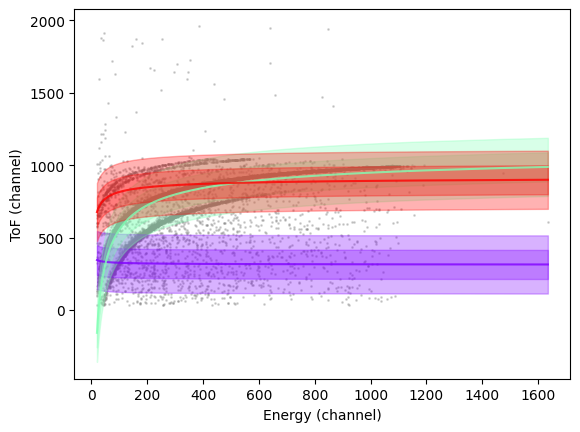

In [194]:
plot_predictions(X, y, y_pred, mlr, fill=True)

# Testing mixed linreg

### Define data

In [195]:
line = np.linspace(start=0, stop=99, num=100, dtype=int)
y_data = np.empty(shape=(len(line)))
for x in line:
    n = x + np.random.normal(loc=0, scale=5)
    if x > 30 and x < 60:
        n = 5*x + np.random.normal(loc=0, scale=5) + 200
    y_data[x] = n

(100,)
(100,)


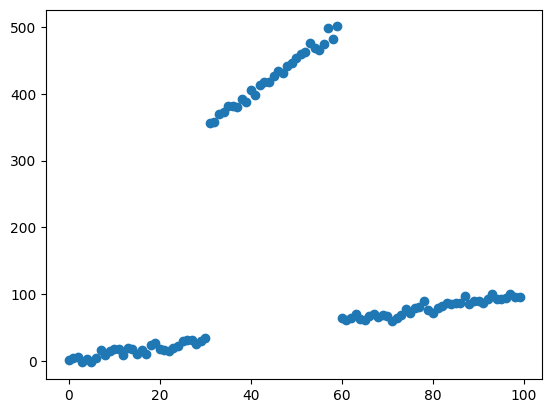

In [196]:
print(line.shape)
print(y_data.shape)
plt.scatter(line, y_data)

#### We'd expect the mixture of linear regression to capture both lines. If bias, then perfectly, if no bias, then two lines where one goes through the two lower, and one which goes through the upper

## Mixture with bias

100%|██████████| 10/10 [00:00<00:00, 1245.93it/s]


{'K': 2, 'beta': np.float64(29902.72803993324), 'W': array([[106.05995511, 137.19602549],
       [  0.64010166,   0.47887514]]), 'pi': array([0.02902185, 0.97097815])}


100%|██████████| 2/2 [00:00<00:00, 121.06it/s]


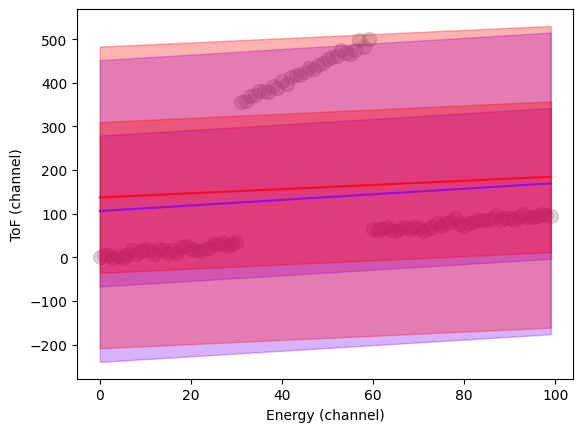

In [203]:
x = Phi(line, [1])
y_data = y_data.reshape((-1, 1))
m = MixtureLinearRegression(K=2, beta=1/y_data.var(), iterations=10, bias=True)
m.train(x, y_data)
print(m.params())
y_pred = m.predict(x)
plot_predictions(x[:,0], y_data, y_pred, m, size=100, fill=True)

## Mixture without bias

100%|██████████| 2/2 [00:00<00:00, 166.39it/s]


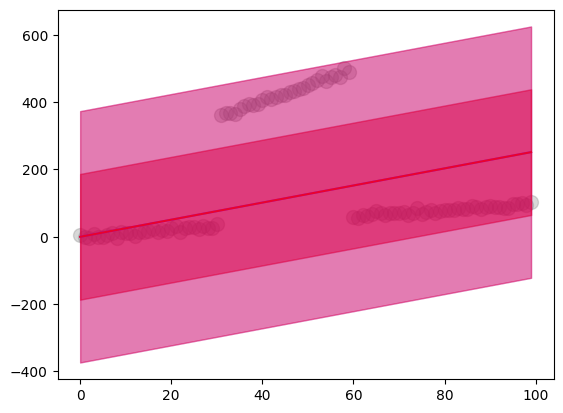

In [177]:
m = MixtureLinearRegression(K=2, beta=1/5, iterations=10, bias=False)
x = Phi(line, [1])
y_data = y_data.reshape((-1, 1))
m.train(x, y_data)
y_pred = m.predict(x)
plot_predictions(x[:,0], y_data, y_pred, m, size=100, fill=True)

### Works as expected. Now we gotta find good features for ToF-ERDA and optimize the class (the N x N matrices are not fast). Regularization terms and other hyperparameters can be optimized